# Imports

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import requests
import math
from PIL import Image
from io import BytesIO
from collections import Counter
from sklearn.model_selection import train_test_split


import wandb
from wandb.keras import WandbCallback

# Tensorflow imports

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, GaussianNoise
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Check if GPU/CPU is connected

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17041451534963096963
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16317916163529622701
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4973462816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8480138967517889007
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12658346196788161847
physical_device_desc: "device: XLA_GPU device"
]


# Dataset exploration

Total number of categories: 150
Total number of images in dataset: 10841


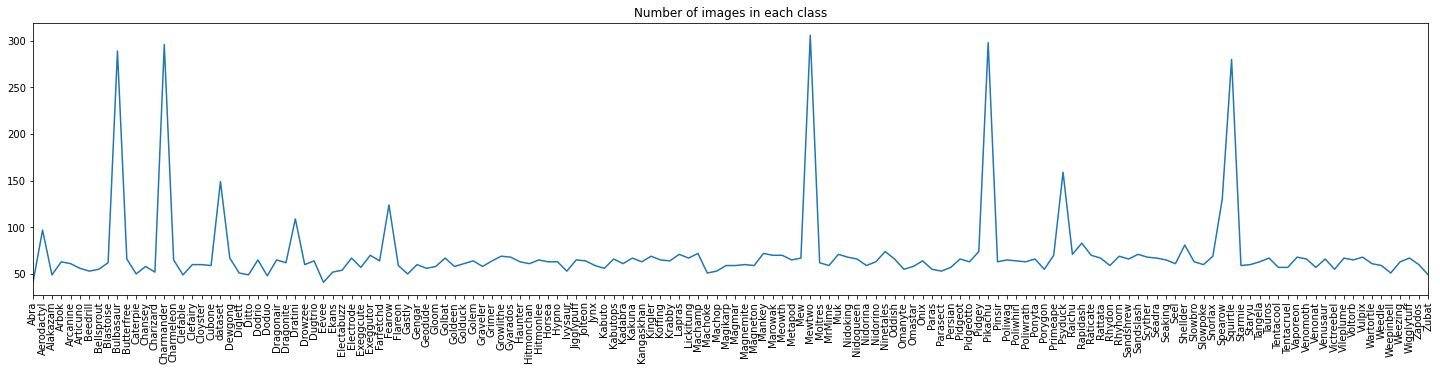

[('Mewtwo', 306), ('Pikachu', 298), ('Charmander', 296), ('Bulbasaur', 289), ('Squirtle', 280)]
['Mewtwo', 'Pikachu', 'Charmander', 'Bulbasaur', 'Squirtle']


In [10]:
# A little bit of data exploration
path = 'dataset/' # Path to directory which contains classes
classes = os.listdir(path) # List of all classes
print(f'Total number of categories: {len(classes)}')

# A dictionary which contains class and number of images in that class
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))
    
print(f'Total number of images in dataset: {sum(list(counts.values()))}')

# Number of images in each clsss plot
fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

# Sort our "counts" dictionary and selecting 5 classes with most number of images
imbalanced = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:5]
print(imbalanced)

# Taking only labels, it will come in handy in future
imbalanced = [i[0] for i in imbalanced]
print(imbalanced)

In [23]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
X = [] # List for images
Y = [] # List for labels

# Loop through all classes
for c in classes:
    # We take only classes that we defined in 'imbalanced' list
    if c in imbalanced:
        dir_path = os.path.join(path, c)
        label = imbalanced.index(c) # Our label is an index of class in 'imbalanced' list
        
        # Reading, resizing and adding image and label to lists
        for i in os.listdir(dir_path):
            img = cv.imread(os.path.join(dir_path, i))
            image = cv.cvtColor(img, cv.COLOR_BGRA2GRAY)
            #image = cv.imread(os.path.join(dir_path, i))
            
            try:
                resized = cv.resize(image, (96, 96)) # Resizing images to (96, 96)
                X.append(resized)
                Y.append(label)
            
            # If we can't read image - we skip it
            except:
                print(os.path.join(dir_path, i), '[ERROR] can\'t read the file')
                continue       
            
print('DONE')

DONE


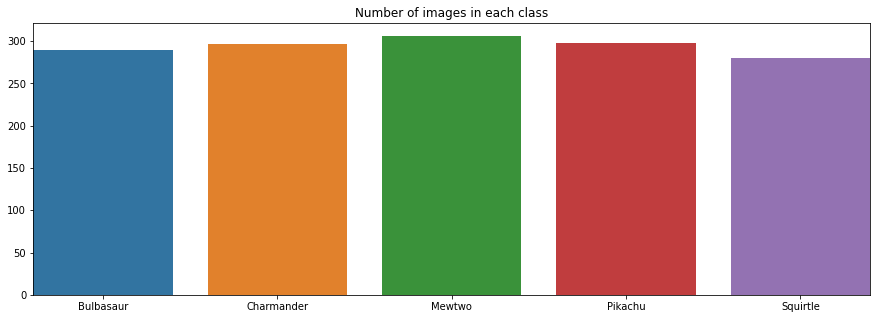

In [24]:
# Counting appearances of each label in labels list
obj = Counter(Y)

# Plotting number of images in each class
fig = plt.figure(figsize = (15, 5))
sns.barplot(x = [imbalanced[i] for i in obj.keys()], y = list(obj.values())).set_title('Number of images in each class')
plt.margins(x=0)
plt.show()

In [26]:
# Convert list with images to numpy array and reshape it 
X = np.array(X).reshape(-1, 96, 96, 1)

# Scaling data in array
X = X / 255.0

# Convert labels to categorical format
y = to_categorical(Y, num_classes = len(imbalanced))

# Splitting data to train and test datasets
# I'll use these datasets only for training, for final predictions I'll use random pictures from internet
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle = True, random_state = 666)

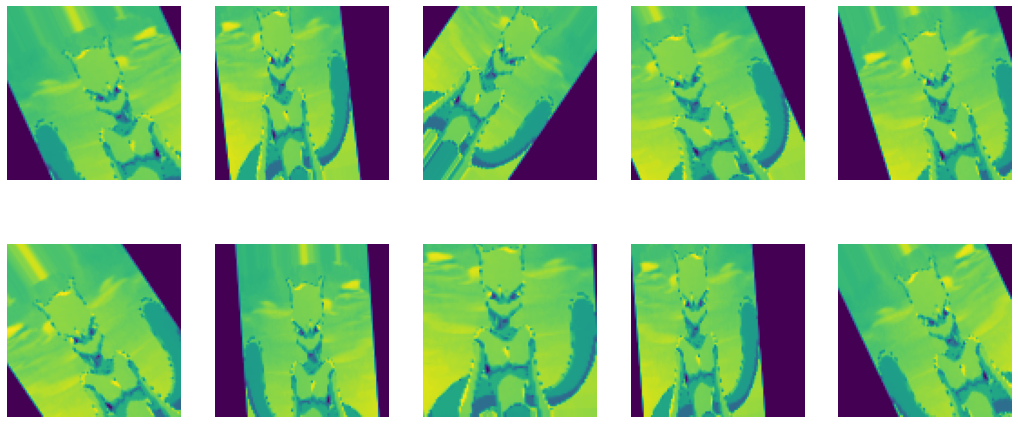

In [28]:
# Defining ImageDataGenerator Iinstance
datagen = ImageDataGenerator(rotation_range = 45, # Degree range for random rotations
                            zoom_range = 0.2, # Range for random zoom 
                            horizontal_flip = True, # Randomly flip inputs horizontally
                            width_shift_range = 0.15, # Range for horizontal shift 
                            height_shift_range = 0.15, # Range for vertical shift 
                            shear_range = 0.2,
                            ) # Shear Intensity

datagen.fit(X_train)

# This piece of code can be used if you eant to look what your datagen doing with your images
img = X[600]
img = img.reshape([-1, 96, 96, 1])

i = 0
fig = plt.figure(figsize = (18, 8))





for i, flow in enumerate(datagen.flow(img, batch_size = 1)):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(np.squeeze(flow[:, :, ::-1]))
    plt.axis('off')
    i += 1

    
    if i >= 10:
        break

# Define hyperparameters for sweep

In [41]:
sweep_config = {
  "name": "NN-zadanie2-test-sweep",
  "method": "random",
  "metric" : {
    'name': 'loss',
    'goal': 'minimize'   
    },
 "parameters" : {
    'optimizer': {
        'values': ['Adam', 'SGD', 'RMSprop','Adagrad']
        },

    'loss': {
        'values': ['categorical_crossentropy','poisson']
        },


    'learning_rate': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
        },

    'batch_size': {
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(16),
        'max': math.log(64),
      },

    'epochs': {
        'distribution': 'int_uniform',
        'min':20,
        'max': 100,
        },
    'dropout_layers':{
       'values': [0.1, 0.25, 0.4, 0.5]
    },
     'pooling':{
         'values' : [2,3]
     }

    
    }   

}

In [42]:
wandb.init(project="NN-zadanie2")
sweep_id = wandb.sweep(sweep_config)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 2zskrf2n
Sweep URL: https://wandb.ai/ramang/uncategorized/sweeps/2zskrf2n


In [53]:
def getOpt(name,rl):
    if name ==  'Adam':
        return keras.optimizers.Adam(learning_rate=rl)
    elif name =='SGD':
        return keras.optimizers.SGD(learning_rate=rl)
    elif name =='RMSprop':
        return keras.optimizers.RMSprop(learning_rate=rl)
    else:
        return keras.optimizers.Adagrad(learning_rate=rl)

def train():
        with wandb.init(config=sweep_config):
        # Specify the other hyperparameters to the configuration
            config = wandb.config
            # Add the config item (layers) to wandb
            if wandb.run:
                # Define the model
                model = Sequential()
                model.add(GaussianNoise(0,input_shape = (96, 96, 1)))
                model.add(Conv2D(32, 3, padding = 'same', activation = 'relu',  kernel_initializer = 'he_normal'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Flatten())
                model.add(Dense(512, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(256, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(len(imbalanced), activation = 'softmax'))

                # model.summary()
                # callbacks
                #checkpoint = ModelCheckpoint('../working/best_model_grey.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
                earlyStoppingCallback = EarlyStopping(monitor='loss', patience=10)

                opt = getOpt(config.optimizer, config.learning_rate)
            
                model.compile(optimizer = opt, loss = config.loss, metrics = ['accuracy'])
                history = model.fit(
                    datagen.flow(X_train, y_train, batch_size = config.batch_size),
                    epochs = config.epochs,
                    validation_data = (X_test, y_test),steps_per_epoch=len(X_train) // config.batch_size, 
                    callbacks = [WandbCallback(),earlyStoppingCallback]
                    )   

In [54]:
%%time
#spustenie sweepu
wandb.agent(sweep_id, function=train, count=20)

wandb: Agent Starting Run: 78q8jlqv with config:
wandb: 	batch_size: 39
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 50
wandb: 	learning_rate: 0.09469264483948309
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/50
30/30 [==============================] - 1s 33ms/step - loss: 9.2599 - accuracy: 0.2377 - val_loss: 381.3000 - val_accuracy: 0.1905
Epoch 2/50
30/30 [==============================] - 1s 27ms/step - loss: 2.8876 - accuracy: 0.2350 - val_loss: 14.0093 - val_accuracy: 0.2007
Epoch 3/50
30/30 [==============================] - 1s 25ms/step - loss: 2.4658 - accuracy: 0.2210 - val_loss: 41.0844 - val_accuracy: 0.2449
Epoch 4/50
30/30 [==============================] - 1s 27ms/step - loss: 2.1757 - accuracy: 0.2227 - val_loss: 4.3530 - val_accuracy: 0.2041
Epoch 5/50
30/30 [==============================] - 1s 25ms/step - loss: 2.6080 - accuracy: 0.2139 - val_loss: 40.8209 - val_accuracy: 0.2109
Epoch 6/50
30/30 [==============================] - 1s 25ms/step - loss: 2.2145 - accuracy: 0.1937 - val_loss: 9.1998 - val_accuracy: 0.1905
Epoch 7/50
30/30 [==============================] - 1s 27ms/step - loss: 2.4766 - accuracy: 0.2218 - val_loss: 6.6016 - val_accuracy: 0.2007
Epoch 8/

epoch,13
loss,2.27144
accuracy,0.25704
val_loss,6.95507
val_accuracy,0.20748
_runtime,17
_timestamp,1618261571
_step,13
best_val_loss,2.82227
best_epoch,7


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▅▅▃▄▃▁▃▄▅▅▆▇█▇
val_loss,█▁▂▁▂▁▁▁▁▁▁▁▇▁
val_accuracy,▃▄▆▄▄▃▄▆█▄▄▄▁▄
_runtime,▁▂▂▂▃▄▄▅▅▅▆▇▇█
_timestamp,▁▂▂▂▃▄▄▅▅▅▆▇▇█
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 9682cz1k with config:
wandb: 	batch_size: 18
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 78
wandb: 	learning_rate: 0.03768147452709522
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/78
65/65 [==============================] - 1s 17ms/step - loss: 3.3980 - accuracy: 0.2463 - val_loss: 18.5842 - val_accuracy: 0.1939
Epoch 2/78
65/65 [==============================] - 1s 14ms/step - loss: 2.0433 - accuracy: 0.2541 - val_loss: 3.4923 - val_accuracy: 0.2109
Epoch 3/78
65/65 [==============================] - 1s 14ms/step - loss: 1.6568 - accuracy: 0.3016 - val_loss: 1.5217 - val_accuracy: 0.3435
Epoch 4/78
65/65 [==============================] - 1s 15ms/step - loss: 1.5950 - accuracy: 0.3051 - val_loss: 1.4784 - val_accuracy: 0.3912
Epoch 5/78
65/65 [==============================] - 1s 14ms/step - loss: 1.5717 - accuracy: 0.3215 - val_loss: 1.5004 - val_accuracy: 0.3503
Epoch 6/78
65/65 [==============================] - 1s 14ms/step - loss: 1.5550 - accuracy: 0.3293 - val_loss: 1.4910 - val_accuracy: 0.3673
Epoch 7/78
65/65 [==============================] - 1s 14ms/step - loss: 1.5612 - accuracy: 0.3336 - val_loss: 1.5354 - val_accuracy: 0.3605
Epoch 8/78
6

epoch,15
loss,1.6165
accuracy,0.32906
val_loss,1.70332
val_accuracy,0.27211
_runtime,20
_timestamp,1618261595
_step,15
best_val_loss,1.41494
best_epoch,14


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▅▅▆▇▇▆▆▇▇█▆█▅▇
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▆▇▆▇▆█▇▆▆▇▇▅▅▄
_runtime,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ryhfpqlr with config:
wandb: 	batch_size: 51
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 60
wandb: 	learning_rate: 0.008359937029422072
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/60
23/23 [==============================] - 2s 69ms/step - loss: 0.7190 - accuracy: 0.2109 - val_loss: 0.5290 - val_accuracy: 0.2279
Epoch 2/60
23/23 [==============================] - 1s 45ms/step - loss: 0.6755 - accuracy: 0.2607 - val_loss: 0.5171 - val_accuracy: 0.2687
Epoch 3/60
23/23 [==============================] - 1s 36ms/step - loss: 0.6721 - accuracy: 0.2589 - val_loss: 0.5256 - val_accuracy: 0.2381
Epoch 4/60
23/23 [==============================] - 1s 36ms/step - loss: 0.6606 - accuracy: 0.2669 - val_loss: 0.5550 - val_accuracy: 0.2109
Epoch 5/60
23/23 [==============================] - 1s 36ms/step - loss: 0.6603 - accuracy: 0.2527 - val_loss: 0.5235 - val_accuracy: 0.1939
Epoch 6/60
23/23 [==============================] - 1s 38ms/step - loss: 0.6572 - accuracy: 0.2562 - val_loss: 0.5376 - val_accuracy: 0.2109
Epoch 7/60
23/23 [==============================] - 1s 36ms/step - loss: 0.6197 - accuracy: 0.3016 - val_loss: 0.5515 - val_accuracy: 0.1803
Epoch 8/60
23

epoch,43
loss,0.52907
accuracy,0.33007
val_loss,0.54469
val_accuracy,0.32313
_runtime,44
_timestamp,1618261653
_step,43
best_val_loss,0.50994
best_epoch,32


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▆▆▆▆▄▄▃▄▃▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▃▄▃▃▅▆▆▅▆▅▅▆▆▆▆▆█▆▇█▇▇▇▆▇▇▆▇██▇▇█▇▇▆▇▇
val_loss,▃▂▂▅▂▃▄▇▄▅▇▇▆▇▇▇█▇█▇▄▄▃▃▄▃▃▂▂▁▁▁▁▂▂▂▂▂▂▄
val_accuracy,▃▄▃▂▁▂▁▂▃▃▂▃▂▃▃▃▂▃▃▂▄▄▆▆▅▇▆▆▇▇▇█▇▇▇▇███▆
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1hjw106n with config:
wandb: 	batch_size: 56
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 45
wandb: 	learning_rate: 0.05498104927354558
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 2


Epoch 1/45
20/20 [==============================] - 1s 62ms/step - loss: 5.8014 - accuracy: 0.2297 - val_loss: 2643.2534 - val_accuracy: 0.2075
Epoch 2/45
20/20 [==============================] - 1s 45ms/step - loss: 2.3964 - accuracy: 0.2752 - val_loss: 168.3187 - val_accuracy: 0.2007
Epoch 3/45
20/20 [==============================] - 1s 47ms/step - loss: 1.8042 - accuracy: 0.2770 - val_loss: 120.8864 - val_accuracy: 0.1905
Epoch 4/45
20/20 [==============================] - 1s 46ms/step - loss: 1.6836 - accuracy: 0.3146 - val_loss: 98.7326 - val_accuracy: 0.1939
Epoch 5/45
20/20 [==============================] - 1s 43ms/step - loss: 1.7181 - accuracy: 0.3250 - val_loss: 14.3944 - val_accuracy: 0.2143
Epoch 6/45
20/20 [==============================] - 1s 45ms/step - loss: 1.6704 - accuracy: 0.3360 - val_loss: 95.2361 - val_accuracy: 0.2007
Epoch 7/45
20/20 [==============================] - 1s 46ms/step - loss: 1.6256 - accuracy: 0.3637 - val_loss: 27.5267 - val_accuracy: 0.1973
Ep

epoch,44
loss,1.25241
accuracy,0.52904
val_loss,1.15708
val_accuracy,0.60204
_runtime,50
_timestamp,1618261711
_step,44
best_val_loss,1.04122
best_epoch,42


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▂▃▃▃▄▄▄▄▅▄▅▅▅▅▆▅▆▆▆▅▆▆▇▇▆▇▇▇▇▇▇▇▇█▇█▇█
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▂▁▁▂▁▃▂▃▂▄▂▁▃▃▄▃▂▄▃▂▅▂▄▆▃▅▆▆▆▆▅▄▆▃█▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: dbfn6r4t with config:
wandb: 	batch_size: 43
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 62
wandb: 	learning_rate: 0.07076268875578666
wandb: 	loss: poisson
wandb: 	optimizer: RMSprop
wandb: 	pooling: 2


Epoch 1/62
27/27 [==============================] - 1s 44ms/step - loss: 1.9891 - accuracy: 0.2226 - val_loss: 2.9613 - val_accuracy: 0.1361
Epoch 2/62
27/27 [==============================] - 1s 33ms/step - loss: 1.0457 - accuracy: 0.2332 - val_loss: 2.4198 - val_accuracy: 0.2007
Epoch 3/62
27/27 [==============================] - 1s 33ms/step - loss: 0.6849 - accuracy: 0.2403 - val_loss: 2.1636 - val_accuracy: 0.1973
Epoch 4/62
27/27 [==============================] - 1s 35ms/step - loss: 0.5890 - accuracy: 0.2527 - val_loss: 1.7348 - val_accuracy: 0.2823
Epoch 5/62
27/27 [==============================] - 1s 37ms/step - loss: 0.5903 - accuracy: 0.2456 - val_loss: 0.7499 - val_accuracy: 0.2517
Epoch 6/62
27/27 [==============================] - 1s 32ms/step - loss: 0.6056 - accuracy: 0.2465 - val_loss: 1.0001 - val_accuracy: 0.2687
Epoch 7/62
27/27 [==============================] - 1s 33ms/step - loss: 0.5961 - accuracy: 0.2491 - val_loss: 2.1149 - val_accuracy: 0.2109
Epoch 8/62
27

epoch,44
loss,0.53746
accuracy,0.37898
val_loss,0.51027
val_accuracy,0.39456
_runtime,47
_timestamp,1618261766
_step,44
best_val_loss,0.46654
best_epoch,32


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▁▂▂▂▂▂▃▃▂▃▄▃▃▄▅▄▅▅▅▆▆▅▆▆▆▆▆▆▆▆██▇▆▇▆▇▆▇
val_loss,█▆▆▅▂▂▆▇▆▇▇▂▂▅▆▄▃▂▅▂▂▁▁▃▂▁▂▂▁▁▂▂▁▂▃▁▁▂▁▁
val_accuracy,▁▂▂▄▃▄▂▂▂▂▂▄▅▄▂▂▅▃▄▄▅▅█▄▃▄▄▄▆█▄▅▇▃▄▄▅▄▇▆
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xxhuj2ix with config:
wandb: 	batch_size: 18
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 81
wandb: 	learning_rate: 0.08700554939884136
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 2


Epoch 1/81
65/65 [==============================] - 1s 22ms/step - loss: 7.3794 - accuracy: 0.2109 - val_loss: 237.3805 - val_accuracy: 0.1905
Epoch 2/81
65/65 [==============================] - 1s 19ms/step - loss: 2.8608 - accuracy: 0.2066 - val_loss: 19.0558 - val_accuracy: 0.2143
Epoch 3/81
65/65 [==============================] - 1s 18ms/step - loss: 2.6691 - accuracy: 0.2040 - val_loss: 8.1294 - val_accuracy: 0.2857
Epoch 4/81
65/65 [==============================] - 1s 17ms/step - loss: 2.5737 - accuracy: 0.2316 - val_loss: 3.2404 - val_accuracy: 0.2075
Epoch 5/81
65/65 [==============================] - 1s 17ms/step - loss: 2.7102 - accuracy: 0.2377 - val_loss: 2.5733 - val_accuracy: 0.2211
Epoch 6/81
65/65 [==============================] - 1s 18ms/step - loss: 2.5322 - accuracy: 0.2118 - val_loss: 3.4019 - val_accuracy: 0.2143
Epoch 7/81
65/65 [==============================] - 1s 18ms/step - loss: 2.5300 - accuracy: 0.2377 - val_loss: 2.5144 - val_accuracy: 0.2313
Epoch 8/81

epoch,28
loss,2.45171
accuracy,0.29732
val_loss,2.4536
val_accuracy,0.20068
_runtime,38
_timestamp,1618261812
_step,28
best_val_loss,1.81855
best_epoch,24


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▁▁▃▃▂▃▃▃▃▃▄▂▅▆▄▅▃▅▄▄▃▂▄▅▅█▆█
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁
val_accuracy,▁▂▅▂▃▂▃▅▂▂▁▃▁▂▅▄▂▂█▂▄▂▃▃▄▆▁▃▂
_runtime,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: mmhygld8 with config:
wandb: 	batch_size: 28
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 44
wandb: 	learning_rate: 0.07669701362991761
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/44
41/41 [==============================] - 1s 26ms/step - loss: 0.6833 - accuracy: 0.2223 - val_loss: 0.5400 - val_accuracy: 0.2313
Epoch 2/44
41/41 [==============================] - 1s 20ms/step - loss: 0.6110 - accuracy: 0.2441 - val_loss: 0.5389 - val_accuracy: 0.2279
Epoch 3/44
41/41 [==============================] - 1s 19ms/step - loss: 0.5741 - accuracy: 0.2319 - val_loss: 0.5507 - val_accuracy: 0.1156
Epoch 4/44
41/41 [==============================] - 1s 19ms/step - loss: 0.5538 - accuracy: 0.2511 - val_loss: 0.5692 - val_accuracy: 0.2109
Epoch 5/44
41/41 [==============================] - 1s 18ms/step - loss: 0.5456 - accuracy: 0.2485 - val_loss: 0.5739 - val_accuracy: 0.2075
Epoch 6/44
41/41 [==============================] - 1s 20ms/step - loss: 0.5397 - accuracy: 0.2668 - val_loss: 0.5438 - val_accuracy: 0.1973
Epoch 7/44
41/41 [==============================] - 1s 20ms/step - loss: 0.5304 - accuracy: 0.2633 - val_loss: 0.5895 - val_accuracy: 0.2415
Epoch 8/44
41

epoch,43
loss,0.49675
accuracy,0.35571
val_loss,0.48091
val_accuracy,0.38776
_runtime,42
_timestamp,1618261866
_step,43
best_val_loss,0.47258
best_epoch,36


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▁▂▂▃▃▃▃▂▄▃▄▄▂▆▆▄▄▅▅▆▅▆▆▆▆▆▇▆▇▇▇▇█▆█▇█▇
val_loss,▅▅▅▆▇▅██▅▆▆▆▅▅▆▄▆▆▆▆▄▃▃▂▂▂▂▂▂▃▂▁▁▁▁▂▁▂▂▁
val_accuracy,▄▄▁▃▃▃▄▄▄▃▃▄▄▄▃▅▄▄▄▅▆▆▇▆▇▇██▇▇▇███▇▇▇▇▆█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3pdlk9r8 with config:
wandb: 	batch_size: 54
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 48
wandb: 	learning_rate: 0.01368617274453442
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/48
21/21 [==============================] - 1s 45ms/step - loss: 2.4411 - accuracy: 0.2667 - val_loss: 224.5452 - val_accuracy: 0.2075
Epoch 2/48
21/21 [==============================] - 1s 37ms/step - loss: 1.9679 - accuracy: 0.2962 - val_loss: 16.6143 - val_accuracy: 0.2789
Epoch 3/48
21/21 [==============================] - 1s 37ms/step - loss: 1.7571 - accuracy: 0.3167 - val_loss: 5.8997 - val_accuracy: 0.2449
Epoch 4/48
21/21 [==============================] - 1s 38ms/step - loss: 1.6394 - accuracy: 0.3595 - val_loss: 3.0686 - val_accuracy: 0.2381
Epoch 5/48
21/21 [==============================] - 1s 35ms/step - loss: 1.5222 - accuracy: 0.3880 - val_loss: 3.5464 - val_accuracy: 0.2721
Epoch 6/48
21/21 [==============================] - 1s 38ms/step - loss: 1.4848 - accuracy: 0.3970 - val_loss: 1.9860 - val_accuracy: 0.2823
Epoch 7/48
21/21 [==============================] - 1s 34ms/step - loss: 1.4073 - accuracy: 0.4211 - val_loss: 2.2524 - val_accuracy: 0.2993
Epoch 8/48

epoch,47
loss,0.64531
accuracy,0.77431
val_loss,0.90786
val_accuracy,0.71769
_runtime,44
_timestamp,1618261914
_step,47
best_val_loss,0.78236
best_epoch,41


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
accuracy,▁▁▂▂▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▁▁▂▂▃▂▂▃▂▃▄▄▄▅▅▅▅▅▅▅▆▅▅▇█▅▅▇██▅▇██▆▅▆█
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rsid7rff with config:
wandb: 	batch_size: 19
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 29
wandb: 	learning_rate: 0.06806011487221775
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 2


Epoch 1/29
61/61 [==============================] - 1s 19ms/step - loss: 4.5696 - accuracy: 0.2509 - val_loss: 58.9195 - val_accuracy: 0.2007
Epoch 2/29
61/61 [==============================] - 1s 16ms/step - loss: 2.1932 - accuracy: 0.2699 - val_loss: 3.9948 - val_accuracy: 0.2211
Epoch 3/29
61/61 [==============================] - 1s 19ms/step - loss: 1.7151 - accuracy: 0.2829 - val_loss: 1.7545 - val_accuracy: 0.2245
Epoch 4/29
61/61 [==============================] - 1s 17ms/step - loss: 1.6586 - accuracy: 0.2872 - val_loss: 1.7205 - val_accuracy: 0.3027
Epoch 5/29
61/61 [==============================] - 1s 17ms/step - loss: 1.6843 - accuracy: 0.3140 - val_loss: 1.7141 - val_accuracy: 0.2925
Epoch 6/29
61/61 [==============================] - 1s 14ms/step - loss: 1.7280 - accuracy: 0.3062 - val_loss: 1.7251 - val_accuracy: 0.3163
Epoch 7/29
61/61 [==============================] - 1s 16ms/step - loss: 1.7082 - accuracy: 0.3088 - val_loss: 1.6407 - val_accuracy: 0.3027
Epoch 8/29
6

epoch,13
loss,1.89362
accuracy,0.27595
val_loss,3.14473
val_accuracy,0.20748
_runtime,18
_timestamp,1618261941
_step,13
best_val_loss,1.50028
best_epoch,11


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▂▁▁▁▁▁▁▂▂▂▂▂▂
accuracy,▁▃▅▅█▇▇█▅▃▂▆▅▄
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▅▄▅▅▄▅▆██▆▁
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇▇█
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇▇█
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 59jiwspg with config:
wandb: 	batch_size: 54
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 84
wandb: 	learning_rate: 0.014197550837628505
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/84
21/21 [==============================] - 1s 53ms/step - loss: 2.3181 - accuracy: 0.2864 - val_loss: 2.2294 - val_accuracy: 0.2619
Epoch 2/84
21/21 [==============================] - 1s 36ms/step - loss: 1.9792 - accuracy: 0.3122 - val_loss: 2.7486 - val_accuracy: 0.2075
Epoch 3/84
21/21 [==============================] - 1s 42ms/step - loss: 1.8556 - accuracy: 0.3541 - val_loss: 1.8866 - val_accuracy: 0.2551
Epoch 4/84
21/21 [==============================] - 1s 39ms/step - loss: 1.7278 - accuracy: 0.3550 - val_loss: 1.7685 - val_accuracy: 0.2483
Epoch 5/84
21/21 [==============================] - 1s 39ms/step - loss: 1.6912 - accuracy: 0.3756 - val_loss: 1.6333 - val_accuracy: 0.2925
Epoch 6/84
21/21 [==============================] - 1s 40ms/step - loss: 1.5960 - accuracy: 0.3640 - val_loss: 1.5953 - val_accuracy: 0.3095
Epoch 7/84
21/21 [==============================] - 1s 41ms/step - loss: 1.5380 - accuracy: 0.4005 - val_loss: 1.5821 - val_accuracy: 0.2891
Epoch 8/84
21

Epoch 59/84
21/21 [==============================] - 1s 37ms/step - loss: 0.8474 - accuracy: 0.6815 - val_loss: 0.9344 - val_accuracy: 0.6633
Epoch 60/84
21/21 [==============================] - 1s 37ms/step - loss: 0.7954 - accuracy: 0.6922 - val_loss: 0.7764 - val_accuracy: 0.7279
Epoch 61/84
21/21 [==============================] - 1s 37ms/step - loss: 0.7685 - accuracy: 0.7190 - val_loss: 0.7691 - val_accuracy: 0.7449
Epoch 62/84
21/21 [==============================] - 1s 42ms/step - loss: 0.7505 - accuracy: 0.7154 - val_loss: 0.7483 - val_accuracy: 0.7415
Epoch 63/84
21/21 [==============================] - 1s 38ms/step - loss: 0.7637 - accuracy: 0.7293 - val_loss: 0.7743 - val_accuracy: 0.7143
Epoch 64/84
21/21 [==============================] - 1s 37ms/step - loss: 0.7719 - accuracy: 0.7038 - val_loss: 0.7944 - val_accuracy: 0.7347
Epoch 65/84
21/21 [==============================] - 1s 44ms/step - loss: 0.7744 - accuracy: 0.7110 - val_loss: 0.7066 - val_accuracy: 0.7517
Epoch 

epoch,83
loss,0.66809
accuracy,0.74219
val_loss,0.89322
val_accuracy,0.72109
_runtime,79
_timestamp,1618262032
_step,83
best_val_loss,0.6897
best_epoch,69


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▂▃▃▃▄▄▄▅▅▅▅▆▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇███████
val_loss,█▆▅▅▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂
val_accuracy,▁▁▂▁▂▂▄▄▅▆▆▇▆▆▆▇▇▇▇▇▇▇███▇█▇███▇███▇██▇█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: n0aioe0e with config:
wandb: 	batch_size: 52
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 73
wandb: 	learning_rate: 0.02677170308385414
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/73
22/22 [==============================] - 1s 46ms/step - loss: 0.7353 - accuracy: 0.1790 - val_loss: 0.5227 - val_accuracy: 0.1565
Epoch 2/73
22/22 [==============================] - 1s 34ms/step - loss: 0.6690 - accuracy: 0.2137 - val_loss: 0.5258 - val_accuracy: 0.2007
Epoch 3/73
22/22 [==============================] - 1s 34ms/step - loss: 0.6632 - accuracy: 0.2075 - val_loss: 0.5263 - val_accuracy: 0.1939
Epoch 4/73
22/22 [==============================] - 1s 33ms/step - loss: 0.6311 - accuracy: 0.2182 - val_loss: 0.5402 - val_accuracy: 0.1973
Epoch 5/73
22/22 [==============================] - 1s 33ms/step - loss: 0.6154 - accuracy: 0.2422 - val_loss: 0.5448 - val_accuracy: 0.1973
Epoch 6/73
22/22 [==============================] - 1s 34ms/step - loss: 0.6043 - accuracy: 0.2342 - val_loss: 0.5483 - val_accuracy: 0.1973
Epoch 7/73
22/22 [==============================] - 1s 34ms/step - loss: 0.5843 - accuracy: 0.2404 - val_loss: 0.5573 - val_accuracy: 0.1973
Epoch 8/73
22

Epoch 59/73
22/22 [==============================] - 1s 37ms/step - loss: 0.5017 - accuracy: 0.3428 - val_loss: 0.5206 - val_accuracy: 0.2823
Epoch 60/73
22/22 [==============================] - 1s 33ms/step - loss: 0.5055 - accuracy: 0.3259 - val_loss: 0.5213 - val_accuracy: 0.2891
Epoch 61/73
22/22 [==============================] - 1s 35ms/step - loss: 0.5017 - accuracy: 0.3384 - val_loss: 0.5200 - val_accuracy: 0.2993
Epoch 62/73
22/22 [==============================] - 1s 35ms/step - loss: 0.5007 - accuracy: 0.3419 - val_loss: 0.5199 - val_accuracy: 0.2925
Epoch 63/73
22/22 [==============================] - 1s 36ms/step - loss: 0.5035 - accuracy: 0.3437 - val_loss: 0.5193 - val_accuracy: 0.2891
Epoch 64/73
22/22 [==============================] - 1s 36ms/step - loss: 0.5022 - accuracy: 0.3277 - val_loss: 0.5144 - val_accuracy: 0.3095
Epoch 65/73
22/22 [==============================] - 1s 36ms/step - loss: 0.5029 - accuracy: 0.3313 - val_loss: 0.5135 - val_accuracy: 0.3095
Epoch 

epoch,66
loss,0.49957
accuracy,0.33482
val_loss,0.51367
val_accuracy,0.31293
_runtime,60
_timestamp,1618262100
_step,66
best_val_loss,0.51304
best_epoch,65


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▃▄▄▃▄▄▅▄▄▅▆▆▅▆▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇█▇▇█▇▇
val_loss,▂▃▅▆▇▅███▇▆▇▆▇▇▆▅▄▅▄▄▄▄▃▃▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁
val_accuracy,▁▃▃▃▃▅▅▄▆▆▆▆▅▆▅▅▆▆▅▅▄▅▅▅▅▄▅▅▆▆▅▆▆▆▆▇▇▇██
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ebrb9kyu with config:
wandb: 	batch_size: 17
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 57
wandb: 	learning_rate: 0.09654927006827653
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/57
69/69 [==============================] - 1s 16ms/step - loss: 2.8839 - accuracy: 0.2686 - val_loss: 4.9371 - val_accuracy: 0.2041
Epoch 2/57
69/69 [==============================] - 1s 14ms/step - loss: 2.0673 - accuracy: 0.2953 - val_loss: 1.9315 - val_accuracy: 0.3265
Epoch 3/57
69/69 [==============================] - 1s 14ms/step - loss: 1.8121 - accuracy: 0.3187 - val_loss: 1.4616 - val_accuracy: 0.3912
Epoch 4/57
69/69 [==============================] - 1s 14ms/step - loss: 1.6639 - accuracy: 0.3463 - val_loss: 1.4383 - val_accuracy: 0.3810
Epoch 5/57
69/69 [==============================] - 1s 13ms/step - loss: 1.5811 - accuracy: 0.3713 - val_loss: 1.5053 - val_accuracy: 0.3844
Epoch 6/57
69/69 [==============================] - 1s 14ms/step - loss: 1.5290 - accuracy: 0.3834 - val_loss: 1.2983 - val_accuracy: 0.4762
Epoch 7/57
69/69 [==============================] - 1s 13ms/step - loss: 1.4556 - accuracy: 0.4102 - val_loss: 1.3743 - val_accuracy: 0.4150
Epoch 8/57
69

epoch,50
loss,1.19493
accuracy,0.51468
val_loss,1.08691
val_accuracy,0.57143
_runtime,51
_timestamp,1618262155
_step,50
best_val_loss,1.02925
best_epoch,49


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▂▃▄▅▅▄▅▅▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇██▆▆▇▇▇██▇▇▇▆▆▇
val_loss,█▃▂▂▁▂▄▂▁▁▁▁▁▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_accuracy,▁▃▄▄▅▄▂▄▆▆▆▅▆▄▅▆▇▇▇▇▇▆▆▆▇▇█▆▇█▇▇▇█▅▆▇▇▆▇
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 43fkfybl with config:
wandb: 	batch_size: 37
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 24
wandb: 	learning_rate: 0.06256800837532961
wandb: 	loss: poisson
wandb: 	optimizer: SGD
wandb: 	pooling: 3


Epoch 1/24
31/31 [==============================] - 1s 31ms/step - loss: 0.7199 - accuracy: 0.1968 - val_loss: 0.5222 - val_accuracy: 0.2517
Epoch 2/24
31/31 [==============================] - 1s 25ms/step - loss: 0.6785 - accuracy: 0.2293 - val_loss: 0.5236 - val_accuracy: 0.2177
Epoch 3/24
31/31 [==============================] - 1s 25ms/step - loss: 0.6550 - accuracy: 0.2337 - val_loss: 0.5304 - val_accuracy: 0.2143
Epoch 4/24
31/31 [==============================] - 1s 25ms/step - loss: 0.6196 - accuracy: 0.2434 - val_loss: 0.5407 - val_accuracy: 0.2075
Epoch 5/24
31/31 [==============================] - 1s 25ms/step - loss: 0.6026 - accuracy: 0.2390 - val_loss: 0.5385 - val_accuracy: 0.2007
Epoch 6/24
31/31 [==============================] - 1s 25ms/step - loss: 0.5916 - accuracy: 0.2417 - val_loss: 0.5370 - val_accuracy: 0.2381
Epoch 7/24
31/31 [==============================] - 1s 26ms/step - loss: 0.5761 - accuracy: 0.2645 - val_loss: 0.5418 - val_accuracy: 0.2551
Epoch 8/24
31

epoch,23
loss,0.51121
accuracy,0.3225
val_loss,0.50319
val_accuracy,0.30272
_runtime,25
_timestamp,1618262189
_step,23
best_val_loss,0.50319
best_epoch,23


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▇▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▃▃▃▃▃▅▅▅▅▆▆▅▅▆▆▇▅▇▇▇▇█▇
val_loss,▄▅▆█▇▇█▇██▆▆▇▆▆▆▄▄▄▃▃▂▁▁
val_accuracy,▄▂▂▁▁▄▅▅▄▅▄▄▃▄▄▃▄▅▄▆▄▆██
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: wpyxg7u0 with config:
wandb: 	batch_size: 54
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 93
wandb: 	learning_rate: 0.08385268402436466
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/93
21/21 [==============================] - 1s 45ms/step - loss: 0.6930 - accuracy: 0.2052 - val_loss: 0.5297 - val_accuracy: 0.1939
Epoch 2/93
21/21 [==============================] - 1s 38ms/step - loss: 0.6469 - accuracy: 0.2016 - val_loss: 0.5207 - val_accuracy: 0.2415
Epoch 3/93
21/21 [==============================] - 1s 37ms/step - loss: 0.5974 - accuracy: 0.2462 - val_loss: 0.5177 - val_accuracy: 0.2245
Epoch 4/93
21/21 [==============================] - 1s 35ms/step - loss: 0.5755 - accuracy: 0.2230 - val_loss: 0.5230 - val_accuracy: 0.2823
Epoch 5/93
21/21 [==============================] - 1s 35ms/step - loss: 0.5531 - accuracy: 0.2319 - val_loss: 0.5205 - val_accuracy: 0.2789
Epoch 6/93
21/21 [==============================] - 1s 34ms/step - loss: 0.5412 - accuracy: 0.2721 - val_loss: 0.5241 - val_accuracy: 0.2279
Epoch 7/93
21/21 [==============================] - 1s 36ms/step - loss: 0.5402 - accuracy: 0.2578 - val_loss: 0.5377 - val_accuracy: 0.2143
Epoch 8/93
21

Epoch 59/93
21/21 [==============================] - 1s 36ms/step - loss: 0.4968 - accuracy: 0.3640 - val_loss: 0.4784 - val_accuracy: 0.3810
Epoch 60/93
21/21 [==============================] - 1s 34ms/step - loss: 0.4866 - accuracy: 0.3782 - val_loss: 0.4839 - val_accuracy: 0.3912
Epoch 61/93
21/21 [==============================] - 1s 37ms/step - loss: 0.4898 - accuracy: 0.3675 - val_loss: 0.4762 - val_accuracy: 0.4354
Epoch 62/93
21/21 [==============================] - 1s 38ms/step - loss: 0.4847 - accuracy: 0.3961 - val_loss: 0.4731 - val_accuracy: 0.4252
Epoch 63/93
21/21 [==============================] - 1s 36ms/step - loss: 0.4942 - accuracy: 0.3720 - val_loss: 0.4780 - val_accuracy: 0.4014
Epoch 64/93
21/21 [==============================] - 1s 37ms/step - loss: 0.4873 - accuracy: 0.3827 - val_loss: 0.4865 - val_accuracy: 0.3605
Epoch 65/93
21/21 [==============================] - 1s 38ms/step - loss: 0.4869 - accuracy: 0.3800 - val_loss: 0.4941 - val_accuracy: 0.3299
Epoch 

epoch,92
loss,0.47575
accuracy,0.43622
val_loss,0.46908
val_accuracy,0.42517
_runtime,81
_timestamp,1618262274
_step,92
best_val_loss,0.46662
best_epoch,91


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇█▇▇▇▇▇█
val_loss,▆▅▅▆▆▇▇█▆▇▇▆▆▆▆▆▅▃▃▄▃▄▃▂▂▂▁▂▂▂▂▂▁▂▂▂▂▁▁▁
val_accuracy,▁▂▃▃▃▃▂▂▃▁▁▂▁▂▃▂▃▆▄▄▄▄▃▆▆▆▇▆▇▇▇▇█▇▆▇▇▇█▇
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 03zxsp0k with config:
wandb: 	batch_size: 17
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 64
wandb: 	learning_rate: 0.08497270673062024
wandb: 	loss: poisson
wandb: 	optimizer: SGD
wandb: 	pooling: 2


Epoch 1/64
69/69 [==============================] - 1s 15ms/step - loss: 0.6643 - accuracy: 0.2608 - val_loss: 0.6071 - val_accuracy: 0.2755
Epoch 2/64
69/69 [==============================] - 1s 13ms/step - loss: 0.5826 - accuracy: 0.2962 - val_loss: 0.5457 - val_accuracy: 0.3163
Epoch 3/64
69/69 [==============================] - 1s 13ms/step - loss: 0.5487 - accuracy: 0.3325 - val_loss: 0.5028 - val_accuracy: 0.3946
Epoch 4/64
69/69 [==============================] - 1s 13ms/step - loss: 0.5333 - accuracy: 0.3273 - val_loss: 0.4893 - val_accuracy: 0.4558
Epoch 5/64
69/69 [==============================] - 1s 13ms/step - loss: 0.5199 - accuracy: 0.3523 - val_loss: 0.4802 - val_accuracy: 0.4082
Epoch 6/64
69/69 [==============================] - 1s 12ms/step - loss: 0.5111 - accuracy: 0.3670 - val_loss: 0.4916 - val_accuracy: 0.3571
Epoch 7/64
69/69 [==============================] - 1s 12ms/step - loss: 0.5093 - accuracy: 0.3636 - val_loss: 0.4820 - val_accuracy: 0.4014
Epoch 8/64
69

epoch,45
loss,0.47306
accuracy,0.44041
val_loss,0.43891
val_accuracy,0.56122
_runtime,45
_timestamp,1618262323
_step,45
best_val_loss,0.43209
best_epoch,28


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
accuracy,▁▂▄▃▄▅▅▆▅▆▅▆▇▆▆▅▅▇▆▇▆▇▇▆▇▇▇▇██▇█▇▇▇▆▇▇▇▇
val_loss,█▆▄▃▃▃▃▂▃▂▂▂▄▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▃▁▁▁▃▂▂▁▁
val_accuracy,▁▂▄▆▄▃▄▅▅▅▆▆▃▅▆▆▆▆▆▇▇▇▇▇███████▇███▅▆▆█▇
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: 61mnc1an with config:
wandb: 	batch_size: 46
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 97
wandb: 	learning_rate: 0.04566183972999969
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/97
25/25 [==============================] - 1s 39ms/step - loss: 0.7019 - accuracy: 0.2356 - val_loss: 0.5199 - val_accuracy: 0.2177
Epoch 2/97
25/25 [==============================] - 1s 32ms/step - loss: 0.6499 - accuracy: 0.2135 - val_loss: 0.5191 - val_accuracy: 0.2313
Epoch 3/97
25/25 [==============================] - 1s 32ms/step - loss: 0.6051 - accuracy: 0.2453 - val_loss: 0.5135 - val_accuracy: 0.3095
Epoch 4/97
25/25 [==============================] - 1s 31ms/step - loss: 0.6019 - accuracy: 0.2338 - val_loss: 0.5189 - val_accuracy: 0.2041
Epoch 5/97
25/25 [==============================] - 1s 30ms/step - loss: 0.5845 - accuracy: 0.2276 - val_loss: 0.5168 - val_accuracy: 0.2483
Epoch 6/97
25/25 [==============================] - 1s 30ms/step - loss: 0.5618 - accuracy: 0.2498 - val_loss: 0.5238 - val_accuracy: 0.2483
Epoch 7/97
25/25 [==============================] - 1s 30ms/step - loss: 0.5453 - accuracy: 0.2586 - val_loss: 0.5205 - val_accuracy: 0.2551
Epoch 8/97
25

Epoch 59/97
25/25 [==============================] - 1s 32ms/step - loss: 0.5002 - accuracy: 0.3339 - val_loss: 0.5016 - val_accuracy: 0.3639
Epoch 60/97
25/25 [==============================] - 1s 32ms/step - loss: 0.5007 - accuracy: 0.3384 - val_loss: 0.4995 - val_accuracy: 0.3912
Epoch 61/97
25/25 [==============================] - 1s 31ms/step - loss: 0.4977 - accuracy: 0.3587 - val_loss: 0.5026 - val_accuracy: 0.3435
Epoch 62/97
25/25 [==============================] - 1s 31ms/step - loss: 0.4960 - accuracy: 0.3552 - val_loss: 0.5024 - val_accuracy: 0.3265
Epoch 63/97
25/25 [==============================] - 1s 30ms/step - loss: 0.4983 - accuracy: 0.3508 - val_loss: 0.5004 - val_accuracy: 0.3367
Epoch 64/97
25/25 [==============================] - 1s 30ms/step - loss: 0.4939 - accuracy: 0.3738 - val_loss: 0.5031 - val_accuracy: 0.3401


epoch,63
loss,0.49391
accuracy,0.37378
val_loss,0.50306
val_accuracy,0.34014
_runtime,57
_timestamp,1618262386
_step,63
best_val_loss,0.49947
best_epoch,59


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▂▁▂▂▃▄▃▃▃▅▃▅▅▅▆▅▆▆▅▆▅▅▆▅▆▇▆▇▆▇▆▇▆█▇▇▆▆▇█
val_loss,▅▄▄▄▅▆▇▇▆▆▆▇▇▇█▇▆▆▆▆▅▅▆▆▇▅▇▆▅▅▄▃▄▃▂▂▁▁▂▂
val_accuracy,▂▂▁▃▃▄▄▄▄▄▄▃▂▄▄▄▄▄▄▄▅▅▃▄▄▅▄▅▄▄▅▅▅▆▆▅▇█▆▆
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 22u064q1 with config:
wandb: 	batch_size: 39
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 33
wandb: 	learning_rate: 0.055571075254253754
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: SGD
wandb: 	pooling: 2


Epoch 1/33
30/30 [==============================] - 1s 35ms/step - loss: 2.3571 - accuracy: 0.2641 - val_loss: 1.9204 - val_accuracy: 0.2415
Epoch 2/33
30/30 [==============================] - 1s 29ms/step - loss: 1.9637 - accuracy: 0.2949 - val_loss: 1.7359 - val_accuracy: 0.3095
Epoch 3/33
30/30 [==============================] - 1s 27ms/step - loss: 1.7661 - accuracy: 0.3213 - val_loss: 1.7896 - val_accuracy: 0.2687
Epoch 4/33
30/30 [==============================] - 1s 27ms/step - loss: 1.6726 - accuracy: 0.3548 - val_loss: 1.7814 - val_accuracy: 0.2279
Epoch 5/33
30/30 [==============================] - 1s 29ms/step - loss: 1.6564 - accuracy: 0.3574 - val_loss: 1.6094 - val_accuracy: 0.2517
Epoch 6/33
30/30 [==============================] - 1s 27ms/step - loss: 1.5771 - accuracy: 0.3776 - val_loss: 1.8428 - val_accuracy: 0.2449
Epoch 7/33
30/30 [==============================] - 1s 29ms/step - loss: 1.5146 - accuracy: 0.3701 - val_loss: 1.5727 - val_accuracy: 0.2925
Epoch 8/33
30

epoch,32
loss,1.09292
accuracy,0.57042
val_loss,1.48641
val_accuracy,0.45578
_runtime,35
_timestamp,1618262428
_step,32
best_val_loss,1.02148
best_epoch,31


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▆▅▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▂▂▃▃▄▃▄▅▄▅▅▅▅▅▆▆▅▆▆▆▆▆▇▇▇▇▇▇▇███
val_loss,█▇▇▇▆▇▅▆▆▄▅▄▄▃▃▂▃▂▂▄▁▁▂▂▁▂▁▃▁▃▃▁▅
val_accuracy,▁▂▂▁▁▁▂▂▂▄▃▄▅▆▆▆▅▇▇▆█▇█▇▇▇█▇█▇▆▇▅
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: pgjm4tqp with config:
wandb: 	batch_size: 49
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 31
wandb: 	learning_rate: 0.0771763598738941
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/31
23/23 [==============================] - 1s 48ms/step - loss: 6.6963 - accuracy: 0.2034 - val_loss: 332.4219 - val_accuracy: 0.2041
Epoch 2/31
23/23 [==============================] - 1s 35ms/step - loss: 2.3247 - accuracy: 0.2247 - val_loss: 19.7786 - val_accuracy: 0.2075
Epoch 3/31
23/23 [==============================] - 1s 39ms/step - loss: 1.9428 - accuracy: 0.2345 - val_loss: 5.4892 - val_accuracy: 0.2007
Epoch 4/31
23/23 [==============================] - 1s 35ms/step - loss: 2.0622 - accuracy: 0.2265 - val_loss: 5.0539 - val_accuracy: 0.2415
Epoch 5/31
23/23 [==============================] - 1s 35ms/step - loss: 2.0124 - accuracy: 0.2256 - val_loss: 4.4523 - val_accuracy: 0.2211
Epoch 6/31
23/23 [==============================] - 1s 34ms/step - loss: 1.9892 - accuracy: 0.2291 - val_loss: 5.4577 - val_accuracy: 0.2177
Epoch 7/31
23/23 [==============================] - 1s 36ms/step - loss: 1.9617 - accuracy: 0.2407 - val_loss: 2.9359 - val_accuracy: 0.2551
Epoch 8/31

epoch,23
loss,1.86454
accuracy,0.27531
val_loss,2.23183
val_accuracy,0.29592
_runtime,26
_timestamp,1618262463
_step,23
best_val_loss,1.51516
best_epoch,18


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▃▃▃▄▅▃▄▃█▃▄▄▅▄▇▅▄▇▆▇▇
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▂▂▄▃▃▅▄▇▁▄▁▅▆▆██▆█▅▇█▆▇
_runtime,▁▁▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: mb2cld2l with config:
wandb: 	batch_size: 30
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 52
wandb: 	learning_rate: 0.05146678708120002
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/52
39/39 [==============================] - 1s 28ms/step - loss: 3.7246 - accuracy: 0.2245 - val_loss: 439.8102 - val_accuracy: 0.2007
Epoch 2/52
39/39 [==============================] - 1s 23ms/step - loss: 2.2538 - accuracy: 0.2454 - val_loss: 18.9526 - val_accuracy: 0.2041
Epoch 3/52
39/39 [==============================] - 1s 22ms/step - loss: 1.7861 - accuracy: 0.2444 - val_loss: 2.1663 - val_accuracy: 0.1905
Epoch 4/52
39/39 [==============================] - 1s 23ms/step - loss: 1.6491 - accuracy: 0.2463 - val_loss: 1.6611 - val_accuracy: 0.2755
Epoch 5/52
39/39 [==============================] - 1s 22ms/step - loss: 1.6854 - accuracy: 0.2498 - val_loss: 1.5800 - val_accuracy: 0.3061
Epoch 6/52
39/39 [==============================] - 1s 22ms/step - loss: 1.6305 - accuracy: 0.2803 - val_loss: 1.5009 - val_accuracy: 0.3061
Epoch 7/52
39/39 [==============================] - 1s 20ms/step - loss: 1.6242 - accuracy: 0.2987 - val_loss: 1.6767 - val_accuracy: 0.3163
Epoch 8/52

epoch,22
loss,1.74755
accuracy,0.30393
val_loss,1.94882
val_accuracy,0.28912
_runtime,25
_timestamp,1618262492
_step,22
best_val_loss,1.35596
best_epoch,10


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
accuracy,▁▂▂▂▂▄▅▆▆▅▆▆▆▆▇▆█▆▇▆▅▅▆
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▃▄▄▄▆▆▇▇▅▇▇▇▇▇▆█▂▅▅▄
_runtime,▁▁▁▂▂▂▃▃▄▄▄▄▅▅▅▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▃▃▄▄▄▄▅▅▅▆▆▇▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: nb3tovvh with config:
wandb: 	batch_size: 43
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 23
wandb: 	learning_rate: 0.005393788066001526
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 2


Epoch 1/23
27/27 [==============================] - 1s 39ms/step - loss: 2.4686 - accuracy: 0.2633 - val_loss: 8.3332 - val_accuracy: 0.2313
Epoch 2/23
27/27 [==============================] - 1s 33ms/step - loss: 1.9463 - accuracy: 0.3057 - val_loss: 4.7216 - val_accuracy: 0.2313
Epoch 3/23
27/27 [==============================] - 1s 33ms/step - loss: 1.7558 - accuracy: 0.3348 - val_loss: 3.8053 - val_accuracy: 0.3265
Epoch 4/23
27/27 [==============================] - 1s 33ms/step - loss: 1.6589 - accuracy: 0.3516 - val_loss: 2.2097 - val_accuracy: 0.2585
Epoch 5/23
27/27 [==============================] - 1s 31ms/step - loss: 1.5635 - accuracy: 0.3631 - val_loss: 3.4425 - val_accuracy: 0.3299
Epoch 6/23
27/27 [==============================] - 1s 30ms/step - loss: 1.4433 - accuracy: 0.4117 - val_loss: 2.8644 - val_accuracy: 0.2517
Epoch 7/23
27/27 [==============================] - 1s 33ms/step - loss: 1.4256 - accuracy: 0.4284 - val_loss: 1.9716 - val_accuracy: 0.2789
Epoch 8/23
27

epoch,22
loss,0.97361
accuracy,0.66078
val_loss,0.9374
val_accuracy,0.67687
_runtime,26
_timestamp,1618262523
_step,22
best_val_loss,0.75411
best_epoch,20


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
accuracy,▁▂▂▃▃▄▄▄▅▅▅▆▇▆▇▇▇▇▇▇▇██
val_loss,█▅▄▂▃▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁
val_accuracy,▂▂▃▂▃▂▂▁▃▅▅▄▄▇▆▅▆▇▇██▇█
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


Wall time: 16min 17s


In [38]:
# model = Sequential()
# #model.add(GaussianNoise(stddev=0,))
# model.add(Conv2D(32, 3, padding = 'same', activation = 'relu',input_shape = (96, 96, 1),  kernel_initializer = 'he_normal'))
# model.add(BatchNormalization(axis = -1))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(512, activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(256, activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(len(imbalanced), activation = 'softmax'))

# # model.summary()

# checkpoint = ModelCheckpoint('../working/best_model.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
# earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)

# model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
# history = model.fit(datagen.flow(X_train, y_train, batch_size = 16), epochs = 20, validation_data = (X_test, y_test),steps_per_epoch=len(X_train) // 16, callbacks = [checkpoint,earlyStoppingCallback])                             

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 2.2904 - accuracy: 0.2890
Epoch 00001: val_accuracy improved from -inf to 0.27551, saving model to ../working\best_model.hdf5
73/73 [==============================] - 2s 21ms/step - loss: 2.2904 - accuracy: 0.2890 - val_loss: 2.2608 - val_accuracy: 0.2755
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 2.1548 - accuracy: 0.2847
Epoch 00002: val_accuracy improved from 0.27551 to 0.29932, saving model to ../working\best_model.hdf5
73/73 [==============================] - 1s 18ms/step - loss: 2.1548 - accuracy: 0.2847 - val_loss: 1.9892 - val_accuracy: 0.2993
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 2.0027 - accuracy: 0.3192
Epoch 00003: val_accuracy did not improve from 0.29932
73/73 [==============================] - 1s 16ms/step - loss: 2.0027 - accuracy: 0.3192 - val_loss: 2.3487 - val_accuracy: 0.1599
Epoch 4/20
73/73 [==============================] - ETA: 0s - loss: 1.

In [ ]:
# # Plot learning curves
# fig = plt.figure(figsize = (17, 4))
    
# plt.subplot(121)
# plt.plot(history.history['accuracy'], label = 'acc')
# plt.plot(history.history['val_accuracy'], label = 'val_acc')
# plt.legend()
# plt.grid()
# plt.title(f'accuracy')

# plt.subplot(122)
# plt.plot(history.history['loss'], label = 'loss')
# plt.plot(history.history['val_loss'], label = 'val_loss')
# plt.legend()
# plt.grid()
# plt.title(f'loss')

